## Problem Statement :
### Use Random Forest to prepare a model on fraud data 
**Treating those who have taxable_income <= 30000 as "Risky" and others are "Good"**

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from collections import Counter
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [2]:
fraud_check = pd.read_csv(r'C:\Users\t5498nk\Desktop\NAVANEETH KADALOORI\DATA SCIENCE\Random Forests\Fraud_Check.csv')
fraud_check

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


# Data Understanding

In [3]:
fraud_check.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

# Descriptive Analysis

In [4]:
fraud_check.shape

(600, 6)

In [5]:
fraud_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.3+ KB


In [6]:
fraud_check[fraud_check.duplicated()].shape

(0, 6)

In [7]:
fraud_check.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


# Feature Engineering
**Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”**

In [8]:
fraud_check['Taxable.Income'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64

#### Converting taxable_income <= 30000 as "Risky" and others are "Good"

In [9]:
fraud_check1 = fraud_check.copy()
fraud_check1['Taxable.Category'] = pd.cut(x = fraud_check1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
fraud_check1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Taxable.Category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


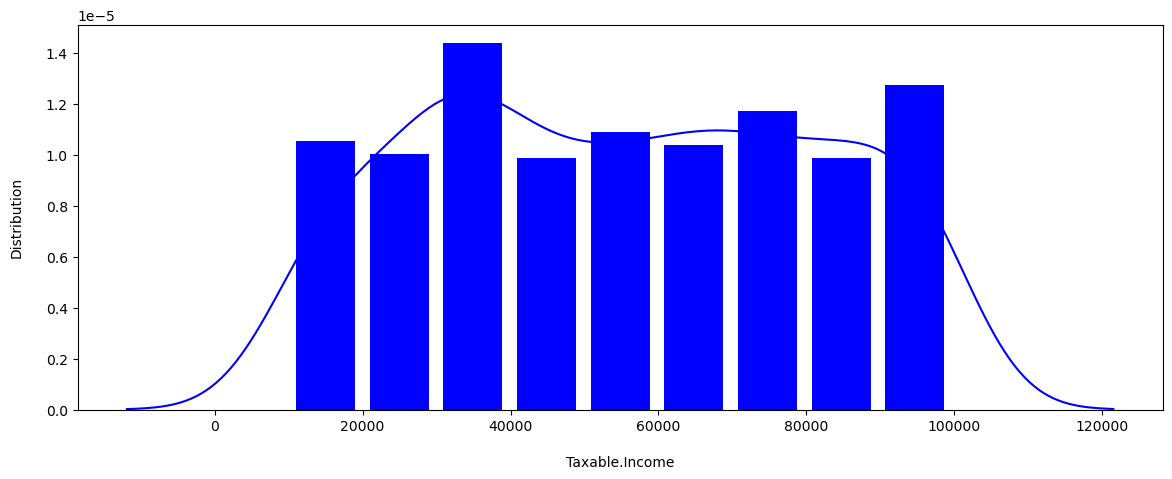

In [10]:
def distplot(param):
    plt.figure(figsize= (14,5))
    sns.distplot(fraud_check[param], color= "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Taxable.Income")

In [11]:
fraud_check1['Taxable.Category'].value_counts()

Taxable.Category
Good     476
Risky    124
Name: count, dtype: int64

In [12]:
fraud_check1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Undergrad         600 non-null    object  
 1   Marital.Status    600 non-null    object  
 2   Taxable.Income    600 non-null    int64   
 3   City.Population   600 non-null    int64   
 4   Work.Experience   600 non-null    int64   
 5   Urban             600 non-null    object  
 6   Taxable.Category  600 non-null    category
dtypes: category(1), int64(3), object(3)
memory usage: 29.0+ KB


In [13]:
categorical_features = fraud_check1.describe(include=["object"]).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')

In [14]:
numerical_features = fraud_check1.describe(include=["int64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

# Exploratory Data Analysis

### Univariate plots

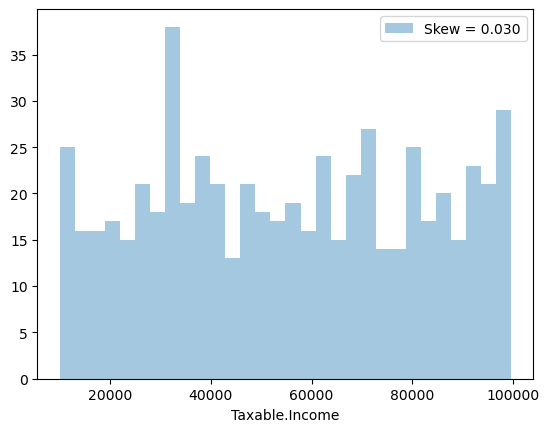

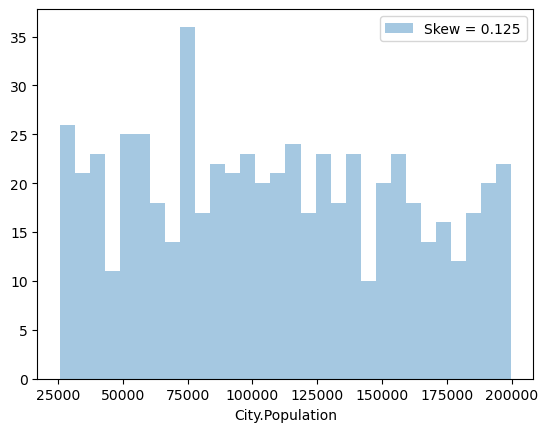

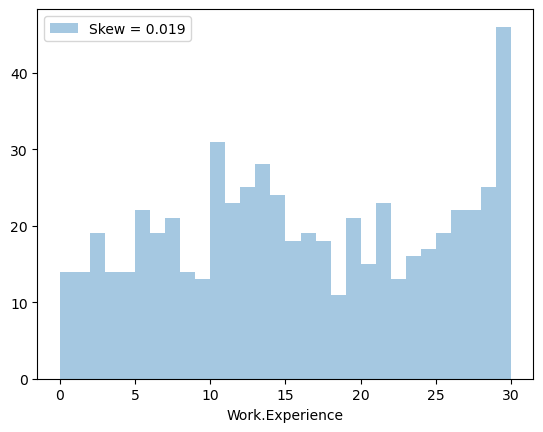

In [15]:
numerical_features=[feature for feature in fraud_check.columns if fraud_check[feature].dtypes != 'O']
for feat in numerical_features:
    skew = fraud_check[feat].skew()
    sns.distplot(fraud_check[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

#### Observation
* None of the features is normally distributed.

### Outliers

In [16]:
numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

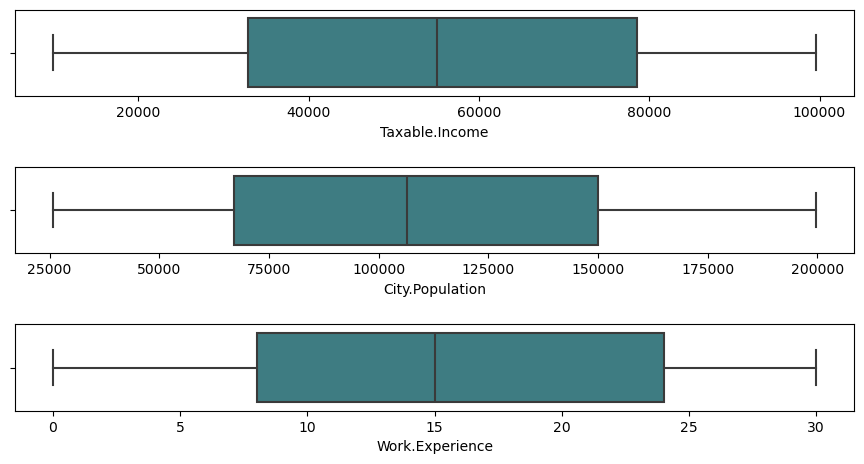

In [17]:
outlier = fraud_check.copy() 
fig, axes = plt.subplots(3,1,figsize=(9,5),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data= outlier,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data= outlier,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data= outlier,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

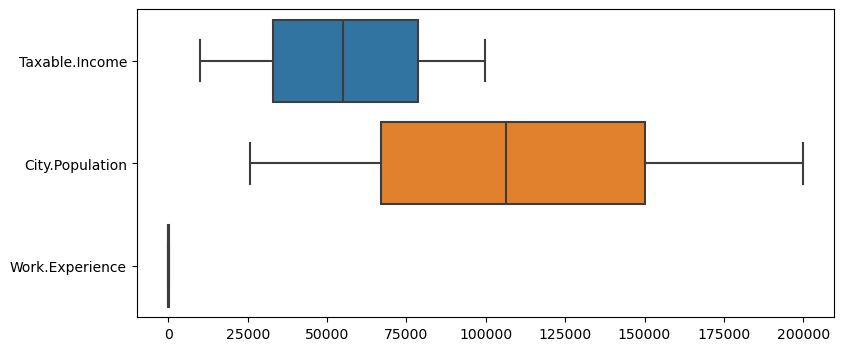

In [18]:
plt.figure(figsize=(9,4))
sns.boxplot(data= fraud_check[numerical_features], orient="h")
plt.show()

#### Observation:
* Work Experience has a mean that is much inferior to the other constituents as we already saw in the previous section.

### Multivariate Analysis
* Let's now proceed by drawing a pairplot to visually examine the correlation between the features.

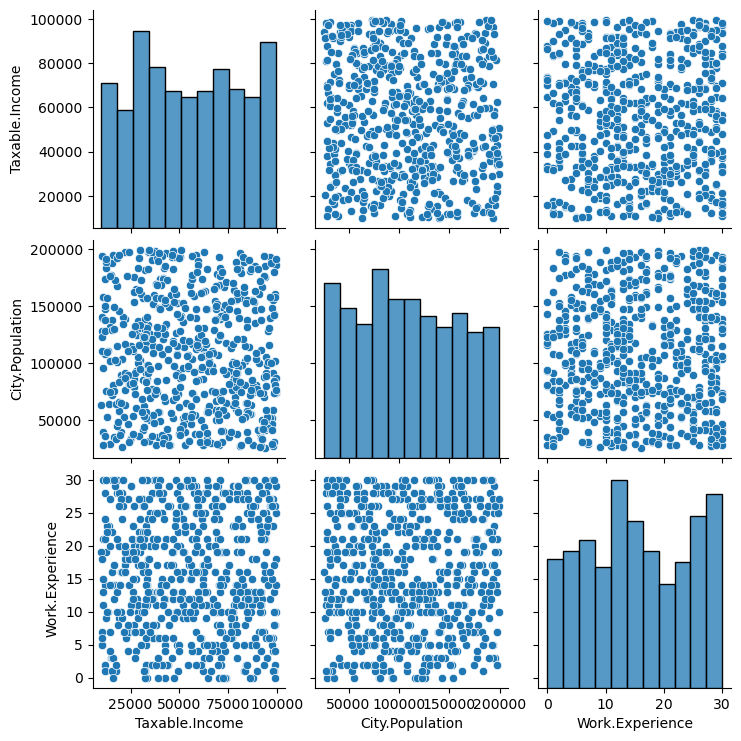

In [19]:
sns.pairplot(fraud_check, palette='coolwarm')
plt.show()

#### Having a look at the correlation matrix

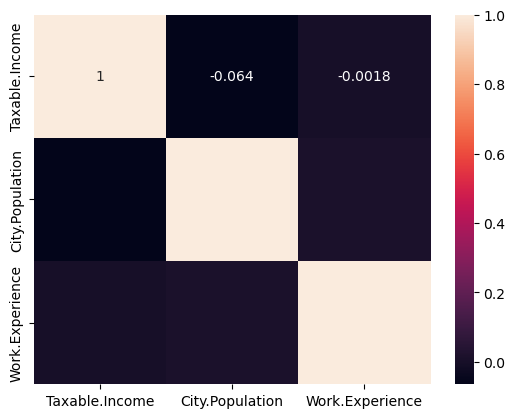

In [20]:
corr=fraud_check.select_dtypes('number').corr()
sns.heatmap(corr, annot=True)
plt.show()

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')


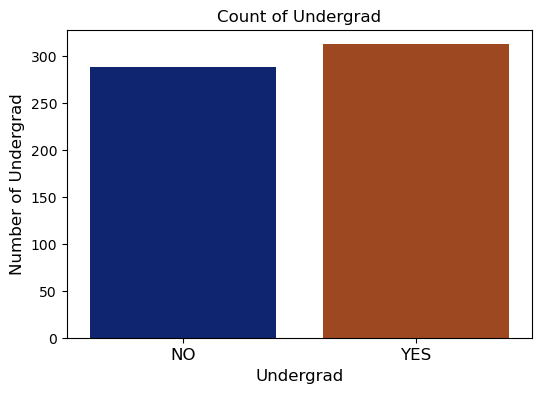

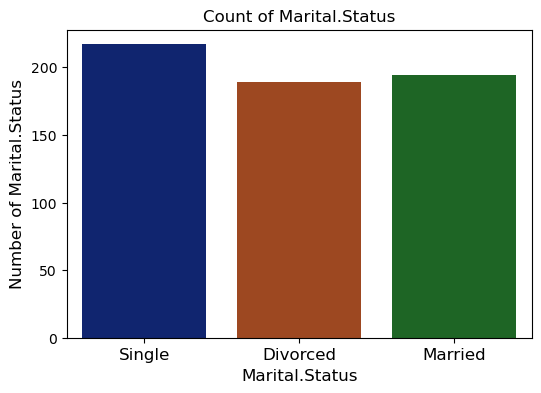

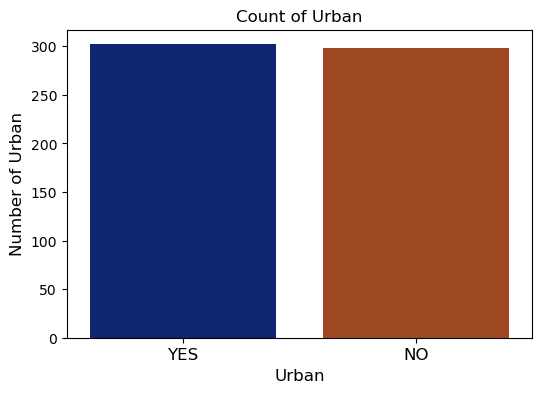

In [21]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(6,4))
    unique = fraud_check[column].value_counts(ascending=True);
   
    plt.title("Count of "+ column)
    sns.countplot(data= fraud_check1, x=column, palette = "dark")
    plt.xticks(rotation = 0, size = 12)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

In [22]:
def catplot(param):
    sns.catplot(x= param, size= 5, aspect= 2, data= fraud_check, y= "Taxable.Income", palette= "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Taxable Income\n")
    plt.show()

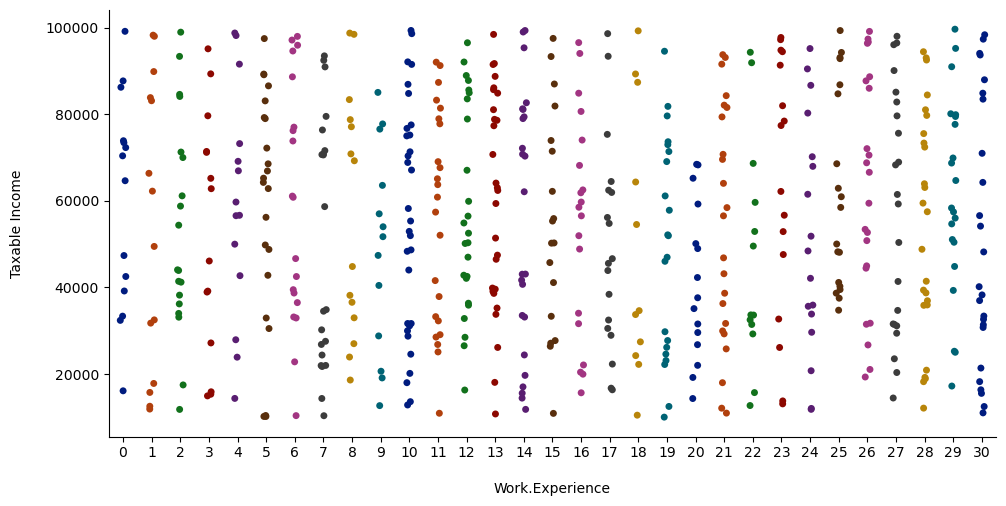

In [23]:
catplot("Work.Experience")

#### Let's plot pair plot to visualise the attributes all at once

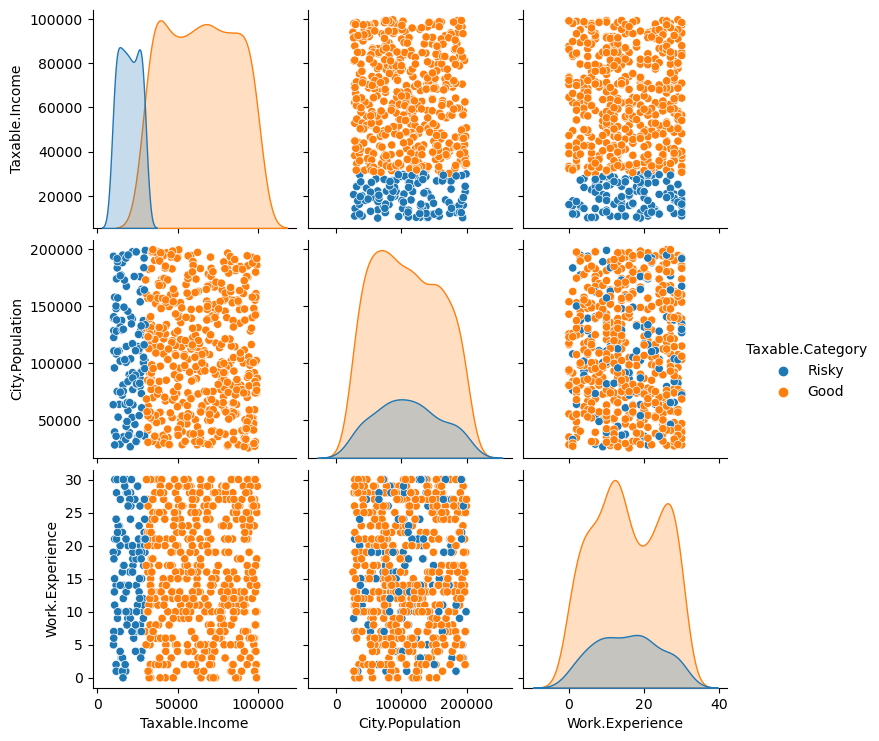

In [24]:
sns.pairplot(data= fraud_check1, hue = 'Taxable.Category')
plt.show()

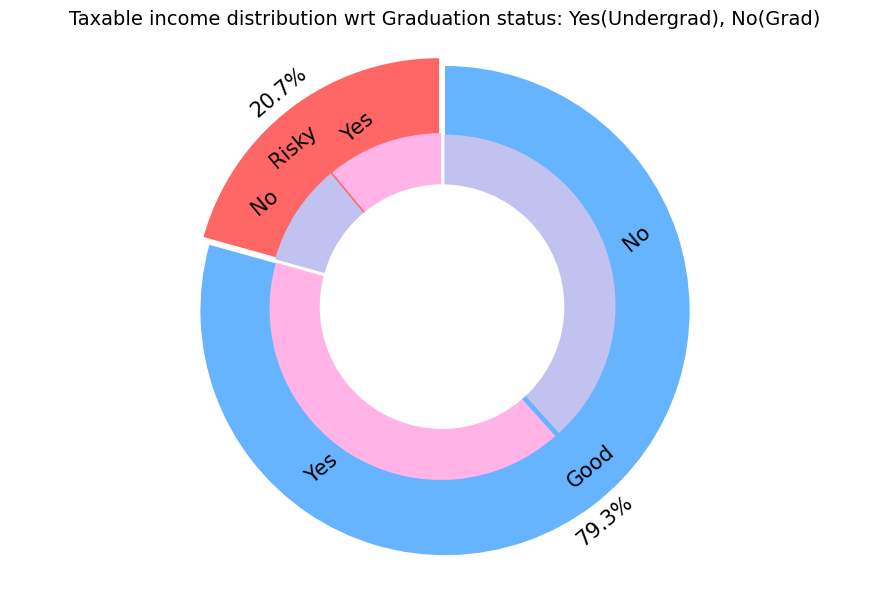

In [25]:
plt.figure(figsize=(9,6))
labels =["Risky", "Good"]
values = [fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Risky'].groupby(by = fraud_check1.Undergrad).count().sum(),
         fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Good'].groupby(by = fraud_check1.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':40}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution wrt Graduation status: Yes(Undergrad), No(Grad)', fontsize= 14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

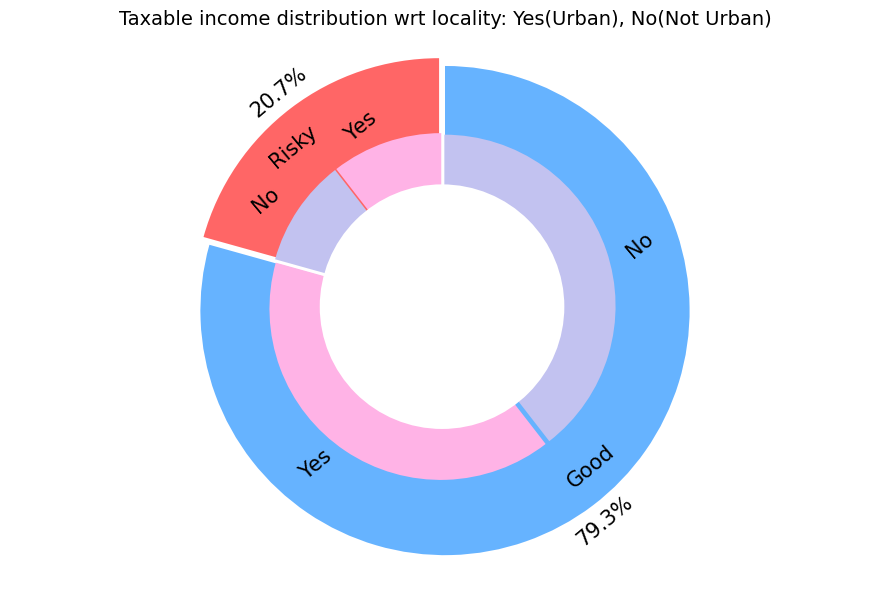

In [26]:
plt.figure(figsize=(9,6))
labels =["Risky", "Good"]
values = [fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Risky'].groupby(by = fraud_check1["Urban"]).count().sum(),
         fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Good'].groupby(by = fraud_check1["Urban"]).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':40}
#Plot
plt.pie(values, labels=labels, autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution wrt locality: Yes(Urban), No(Not Urban)', fontsize=14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

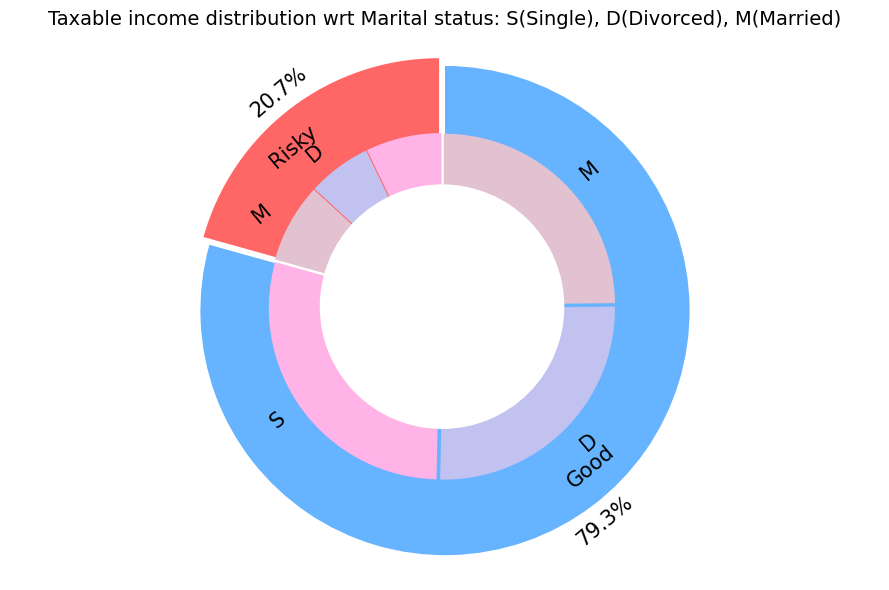

In [27]:
plt.figure(figsize=(9,6))
labels =["Risky", "Good"]
values = [fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Risky'].groupby(by = fraud_check1["Marital.Status"]).count().sum(),
         fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Good'].groupby(by = fraud_check1["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#e2c2d0','#ffb3e6', '#c2c2f0', '#e2c2d0']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':40}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution wrt Marital status: S(Single), D(Divorced), M(Married)', fontsize=14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

In [28]:
fraud_check_dummi = fraud_check1.copy()
fraud_check_dummi.drop(['Taxable.Income'],axis=1, inplace =True)
fraud_check_dummi = pd.get_dummies(fraud_check_dummi.iloc[:,:-1])
fraud_check_dummi.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,True,False,False,False,True,False,True
1,134075,18,False,True,True,False,False,False,True
2,160205,30,True,False,False,True,False,False,True
3,193264,15,False,True,False,False,True,False,True
4,27533,28,True,False,False,True,False,True,False


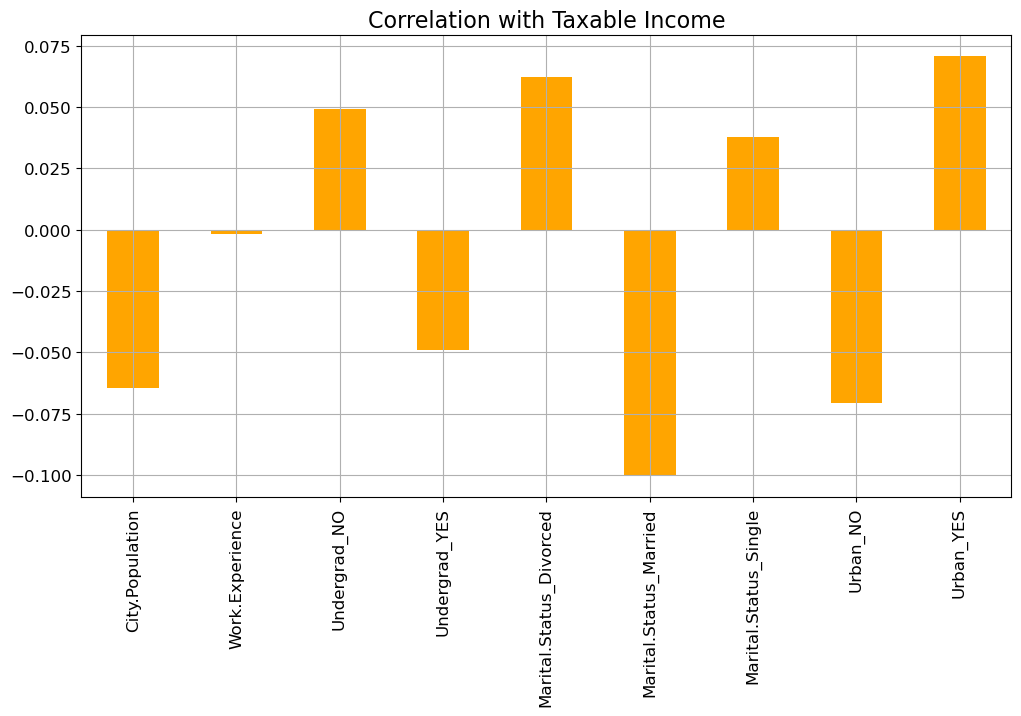

In [29]:
fraud_check2 = fraud_check_dummi.copy()

correlations = fraud_check2.corrwith(fraud_check1['Taxable.Income'])                                     
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize = (12,6), fontsize = 12, color = 'orange', rot = 90, grid = True)
plt.title('Correlation with Taxable Income',fontsize = "16")
plt.show()

### Checking for Imbalanced or balanced dataset with regards to the Target

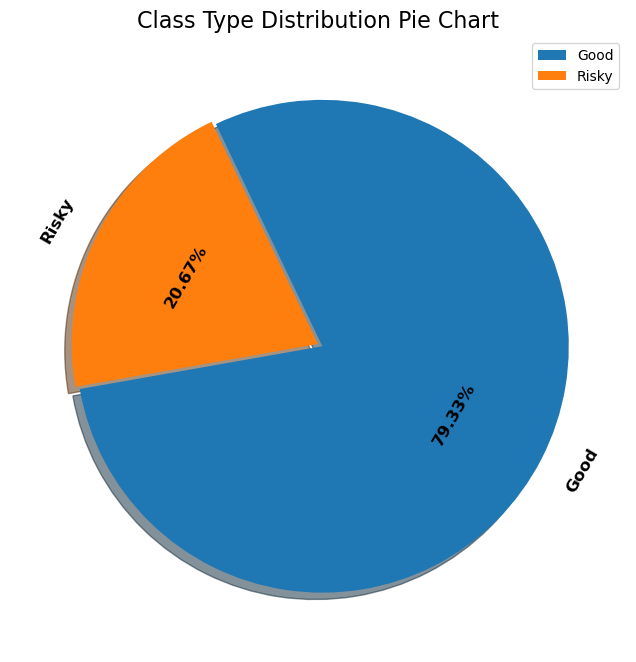

In [30]:
plt.figure(figsize = (9,8))
plt.pie(fraud_check1['Taxable.Category'].value_counts(), labels= fraud_check1['Taxable.Category'].unique(),
       explode = [0.02,0.0], autopct= '%.2f%%', shadow= True, startangle= 190,
       textprops = {'size':'large', 'fontweight':'bold', 'rotation': 60, 'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 16)
plt.show()

**Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations.**

Here, the class “Good” is called the majority class, and the much smaller in size “Risky” class is called the minority class.

In [31]:
countNotermdeposit = len(fraud_check1[fraud_check1['Taxable.Category'] == 'Good'])
counthavetermdeposit = len(fraud_check1[fraud_check1['Taxable.Category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(fraud_check1['Taxable.Category']))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(fraud_check1['Taxable.Category']))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [32]:
fraud_check1['Taxable.Category'].value_counts()

Taxable.Category
Good     476
Risky    124
Name: count, dtype: int64

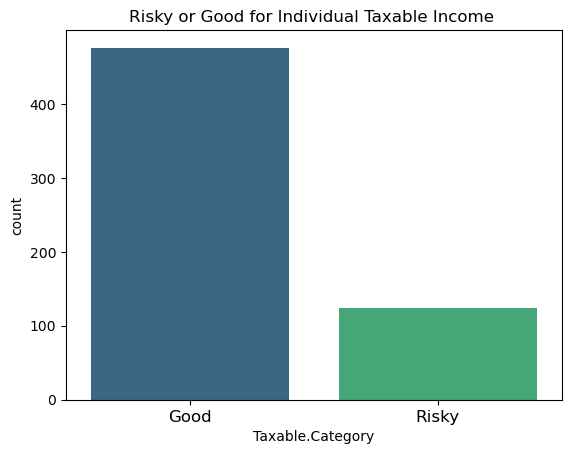

In [33]:
sns.countplot(x='Taxable.Category', data= fraud_check1, palette = 'viridis', 
              order=fraud_check1['Taxable.Category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')
plt.show()

# Data Pre-Processing
Feature Selection Technique

In [34]:
fraud_check1.columns

Index(['Undergrad', 'Marital.Status', 'Taxable.Income', 'City.Population',
       'Work.Experience', 'Urban', 'Taxable.Category'],
      dtype='object')

In [35]:
fraud_check3 = fraud_check1.copy()
fraud_check3.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','City.Population':'City_Population','Work.Experience':'Work_Experience','Taxable.Category':'Taxable_Category'}, inplace = True)
fraud_check3.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = fraud_check3.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'Taxable_Category'], dtype='object')

### Lable Encoding

#### Creating dummy vairables of the categorical features

In [36]:
fraud_check3.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'Taxable_Category'],
      dtype='object')

In [37]:
le = LabelEncoder()
for col in categorical_features:
        le.fit(fraud_check3[col])
        fraud_check3[col] = le.transform(fraud_check3[col])
fraud_check3.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,Taxable_Category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


### Feature Selection Technique

In [38]:
fraud_check4 = fraud_check1.copy()
fraud_check4.drop('Taxable.Income',axis=1, inplace =True)
fraud_check4 = pd.get_dummies(fraud_check4.iloc[:,:-1])
fraud_check4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,True,False,False,False,True,False,True
1,134075,18,False,True,True,False,False,False,True
2,160205,30,True,False,False,True,False,False,True
3,193264,15,False,True,False,False,True,False,True
4,27533,28,True,False,False,True,False,True,False


In [39]:
fraud_check4['Taxable_Income'] = fraud_check1['Taxable.Category']
fraud_check4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,True,False,False,False,True,False,True,Good
1,134075,18,False,True,True,False,False,False,True,Good
2,160205,30,True,False,False,True,False,False,True,Good
3,193264,15,False,True,False,False,True,False,True,Good
4,27533,28,True,False,False,True,False,True,False,Good


In [40]:
le = LabelEncoder()
le.fit(fraud_check4["Taxable_Income"])
fraud_check4["Taxable_Income"]=le.transform(fraud_check4["Taxable_Income"])
fraud_check4.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,True,False,False,False,True,False,True,0
1,134075,18,False,True,True,False,False,False,True,0
2,160205,30,True,False,False,True,False,False,True,0
3,193264,15,False,True,False,False,True,False,True,0
4,27533,28,True,False,False,True,False,True,False,0


#### Split into input (x) and output (y) variables

In [41]:
x = fraud_check4.iloc[:, :-1]
y=  fraud_check4.Taxable_Income

#### Feature extraction

In [42]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(x, y)

#### Summarize scores

In [43]:
scores = fit.scores_
features = fit.transform(x)

In [44]:
score_fraud_check = pd.DataFrame(list(zip(x.columns, scores)), columns =['Feature','Score'])
score_fraud_check.sort_values(by="Score", ascending=False, inplace=True)
score_fraud_check

,Feature,Score
0,City.Population,2045.643886
5,Marital.Status_Married,0.756912
4,Marital.Status_Divorced,0.302172
6,Marital.Status_Single,0.095850
2,Undergrad_NO,0.048929
3,Undergrad_YES,0.045165
1,Work.Experience,0.011709
7,Urban_NO,0.007044
8,Urban_YES,0.006951


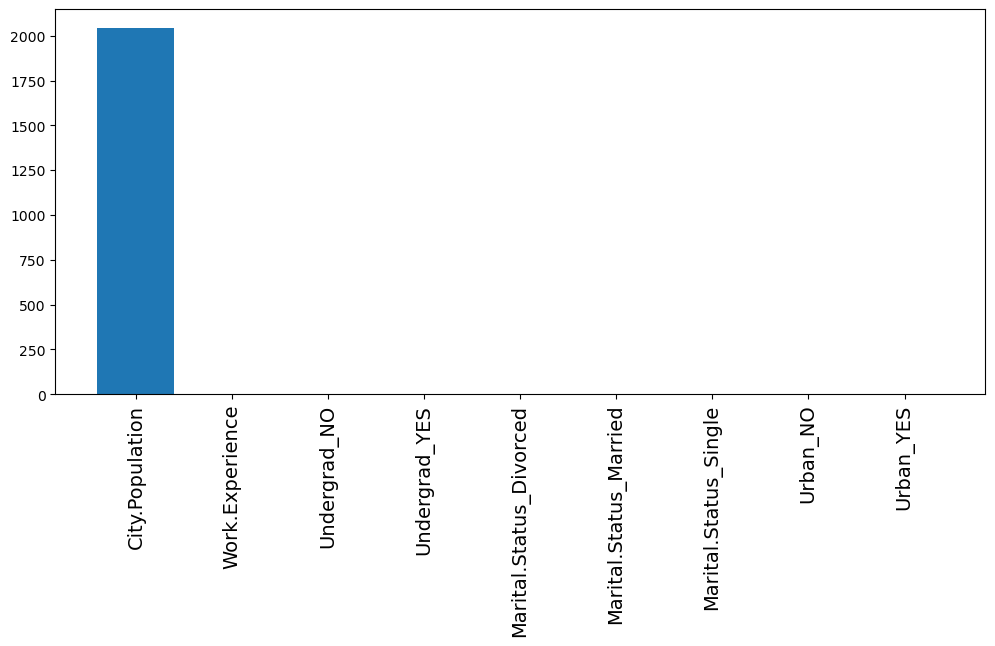

In [45]:
fig, axes = plt.subplots(figsize=(12,5))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 14)
plt.show()

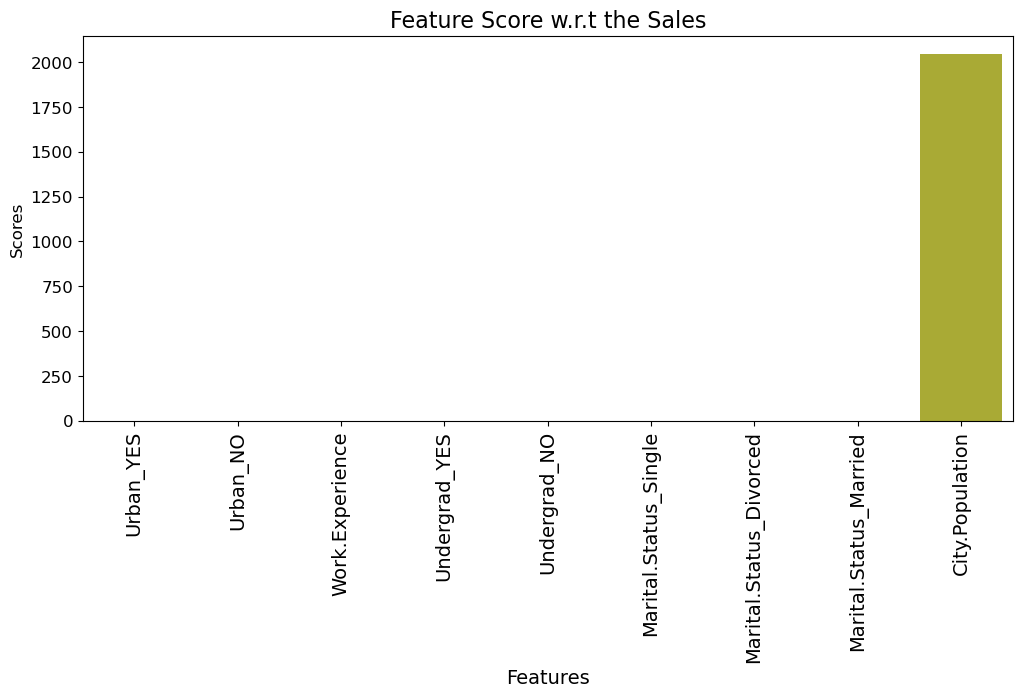

In [46]:
plt.figure(figsize=(12,5))
sns.barplot(x='Feature', y="Score", data=score_fraud_check, order=score_fraud_check.sort_values('Score').Feature)
plt.xlabel("Features", size=14)
plt.ylabel("Scores", size=12)
plt.yticks(rotation = 0, fontsize = 12)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Score w.r.t the Sales", size=16)
plt.show()

# Random Forest Built-in Feature Importance

In [47]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)
rf_classifier.fit(x, y)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {'max_depth': [2,3,5,10,20], 'min_samples_leaf': [5,10,20,50,100,200],'n_estimators': [10,25,30,50,100,200]}

grid_search = GridSearchCV(estimator= rf, param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x, y)
rf_best = grid_search.best_estimator_

print('Checking the oob score :', rf_classifier.oob_score_)
print('Best Score             :', grid_search.best_score_)
print('RF Best Model          :', rf_best)

Fitting 4 folds for each of 180 candidates, totalling 720 fits
Checking the oob score : 0.7933333333333333
Best Score             : 0.7933333333333333
RF Best Model          : RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)


### Now let’s sort the data with the help of feature importance

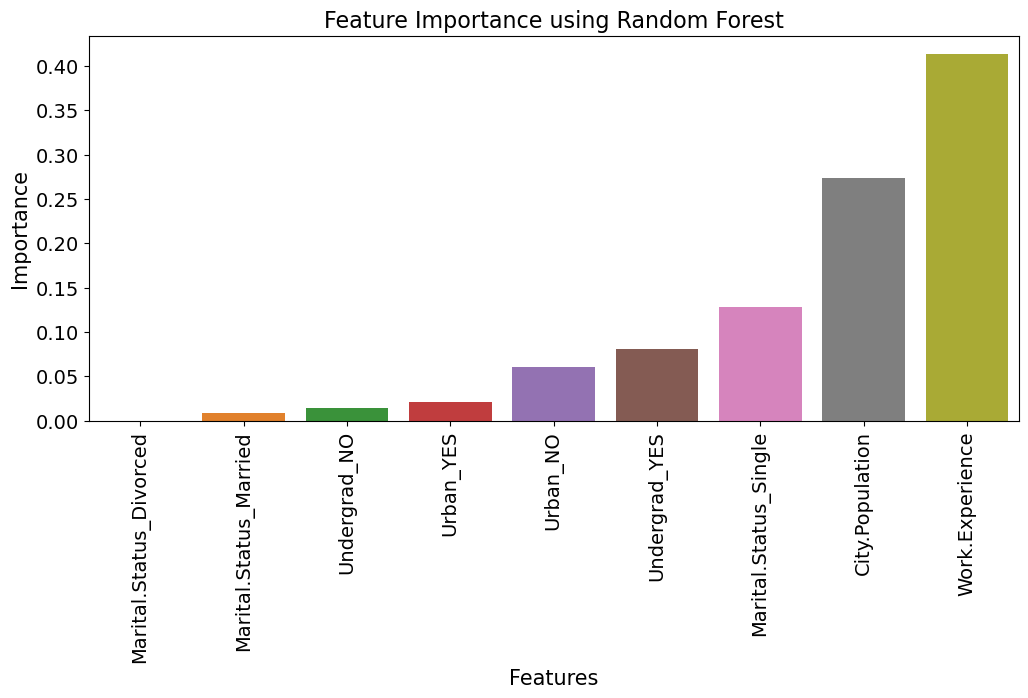

In [48]:
rf_best.feature_importances_
imp_df = pd.DataFrame({"Feature": x.columns, "Importance": rf_best.feature_importances_})

plt.figure(figsize=(12,5))
sns.barplot(x= 'Feature', y= "Importance", data= imp_df, order= imp_df.sort_values('Importance').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Importance using Random Forest", size=16)
plt.show()

# Test Train Split With Imbalanced Dataset

In [49]:
x = fraud_check3.drop('Taxable_Category',axis=1)
y = fraud_check3['Taxable_Category']

In [50]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [51]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (420, 5)
Shape of x_test  :  (180, 5)
Shape of y_train :  (420,)
Shape of y_test  :  (180,)


### StratifiedKFold

In [52]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_x, test_x = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data :',counter_train)
print('Testing Data  :',counter_test)

Training Data : Counter({0: 429, 1: 111})
Testing Data  : Counter({0: 47, 1: 13})


# About Stratify
* Stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify

# Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [53]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [54]:
rf_clf1 = RandomForestClassifier(n_estimators=100)
rf_clf1.fit(train_x, train_y)

print_score(rf_clf1, train_x, train_y, test_x, test_y, train=True)
print_score(rf_clf1, train_x, train_y, test_x, test_y, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    429.0  111.0       1.0      540.0         540.0
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [  0 111]]

Test Result:
Accuracy Score: 73.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy  macro avg  weighted avg
precision   0.771930   0.0  0.733333   0.385965      0.604678
recall      0.936170   0.0  0.733333   0.468085      0.733333
f1-score    0.846154   0.0  0.733333   0.423077      0.662821
support    47.000000  13.0  0.733333  60.000000     60.000000
_______________________________________________
Confusion Matrix: 
 [[44  3]
 [13  0]]


# Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

In [55]:
rf_clf2 = RandomForestClassifier(n_estimators=100)
rf_clf2.fit(x_train, y_train)

print_score(rf_clf2, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf2, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    333.0  87.0       1.0      420.0         420.0
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [  0  87]]

Test Result:
Accuracy Score: 77.22%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.789773   0.0  0.772222    0.394886      0.627431
recall       0.972028   0.0  0.772222    0.486014      0.772222
f1-score     0.871473   0.0  0.772222    0.435737      0.692337
support    143.000000  37.0  0.772222  180.000000    180.000000
_______________________________________________
Confusion Matrix: 
 [[139   4]
 [ 

#### Observation:
* In both the condition, due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

# Handling imbalance data using SMOTE based techniques
**Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information. In this article, I am specifically covering some special data augmentation oversampling techniques: SMOTE and its related counterparts.**

In [56]:
x = fraud_check3.drop(['Taxable_Category'], axis=1)
y = fraud_check3['Taxable_Category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [57]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (420, 5)
Shape of x_test  :  (180, 5)
Shape of y_train :  (420,)
Shape of y_test  :  (180,)


# SMOTE Oversampling technique

In [59]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [66]:
from imblearn.over_sampling import SMOTE, ADASYN

In [67]:
counter = Counter(y_train)
print('Before',counter)
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


# ADASYN: Adaptive Synthetic Sampling Approach

In [68]:
counter = Counter(y_train)
print('Before',counter)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


# Hybridization: SMOTE + Tomek Links

In [71]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [74]:
from imblearn.combine import SMOTETomek, SMOTEENN

In [75]:
counter = Counter(y_train)
print('Before',counter)
smtom = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 239, 1: 239})


# Hybridization: SMOTE + ENN

In [76]:
counter = Counter(y_train)
print('Before',counter)
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 92, 1: 71})


# Performance Analysis after Resampling

In [77]:
sample_data = {'ACTUAL':[x_train, y_train], 'SMOTE':[x_train_sm, y_train_sm], 'ADASYN':[x_train_ada, y_train_ada],
               'SMOTE_TOMEK':[x_train_smtom, y_train_smtom], 'SMOTE_ENN':[x_train_smenn, y_train_smenn]}

In [78]:
def test_eval(clf_model, x_test, y_test, algo= None, sampling=None):
    # Test set prediction
    y_prob = clf_model.predict_proba(x_test)
    y_pred = clf_model.predict(x_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    
    f1        = f1_score(y_test, y_pred, average='micro')
    recall    = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    return algo,precision,recall,f1,sampling

In [79]:
model_params = {'random-forest' : {'model' : RandomForestClassifier(), 'params' : {"n_estimators": [5, 10, 15, 20, 25], 
                'max_depth': [i for i in range(5,16,2)], 'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
                'min_samples_leaf': [1, 2, 5], 'criterion': ['gini', 'entropy'], 'max_features': ['log2', 'sqrt', 'auto']}}}

In [80]:
cv = StratifiedKFold (n_splits=5, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resampl , data in sample_data.items():
        clf3 = RandomizedSearchCV (model_hp['model'], model_hp['params'], cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf3.fit(data[0], data[1])
        clf_best1 = clf3.best_estimator_
        print('='*60)
        print(model+' with ' + resampl)
        print('-'*60)
        output.append(test_eval(clf_best1, x_test, y_test, model, resampl))

random-forest with ACTUAL
------------------------------------------------------------
Confusion Matrix
[[143   0]
 [ 37   0]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180
 

random-forest with SMOTE
------------------------------------------------------------
Confusion Matrix
[[98 45]
 [27 10]] 

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       143
           1       0.18      0.27      0.22        37

    accuracy                           0.60       180
   macro avg       0.48      0.48      0.47       180
weighted avg       0.66      0.60      0.63       180
 

random-forest with ADASYN
-------------------

### As the results can be compared, ADASYN technique gave the best results we are going to use it further

In [81]:
counter = Counter(y_train)
print('Before',counter)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


In [82]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.3,random_state=0, stratify=y_train_ada)

counter = Counter(y_train)
print('Train Counter    : ',counter)
counter = Counter(y_test)
print('Test Counter     : ',counter)
print("Shape of X_train : ",x_train.shape)
print("Shape of X_test  : ", x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Train Counter    :  Counter({0: 233, 1: 229})
Test Counter     :  Counter({0: 100, 1: 98})
Shape of X_train :  (462, 5)
Shape of X_test  :  (198, 5)
Shape of y_train :  (462,)
Shape of y_test  :  (198,)


# Random Forest
Random Forest is one of the most popular and most powerful machine learning algorithms. It is a type of ensemble machine learning algorithm called Bootstrap Aggregation or bagging.
To improve performance of Decision trees, we can use many trees with a random sample of features chosen as the split.

# Random Forest hyperparameter tuning

#### Base model

In [83]:
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 10) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [84]:
loc = np.array(score_array).max()
score_array.index(loc)+1

18

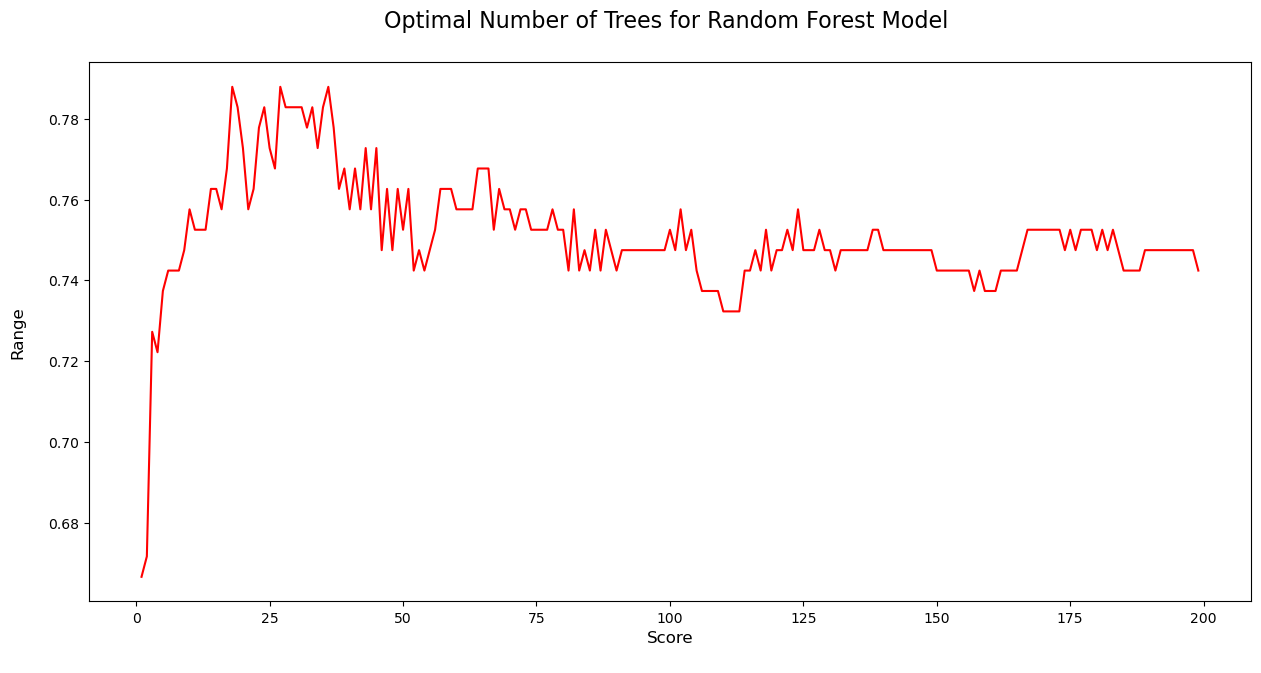

In [85]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = 'r')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontsize = "16")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

# Randomized Search Cross Validation

In [86]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True})
Train Result:
Accuracy Score: 93.29%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.939130    0.926724    0.9329    0.932927      0.932981
recall       0.927039    0.938865    0.9329    0.932952      0.932900
f1-score     0.933045    0.932755    0.9329    0.932900      0.932901
support    233.000000  229.000000    0.9329  462.000000    462.000000
_______________________________________________
Confusion Matrix: 
 [[216  17]
 [ 14 215]]

Test Result:
Accuracy Score: 72.73%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision    0.75000   0.707547  0.727273    0.728774      0.728988

#### Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define

# Grid Search Cross Validation

In [88]:
from imblearn.pipeline import Pipeline

In [89]:
pipe_rfc = Pipeline([('scl', StandardScaler()), ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )])
param_grid_rfc =  [{'rfc__n_estimators': [100, 200,300,400], 'rfc__max_features':[0.05 , 0.1],
                    'rfc__max_depth': [None, 5], 'rfc__min_samples_split': [0.005, 0.01]}]

kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

start = time()
grid_rfc = grid_rfc.fit(x_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
RFC grid search took 59.936 seconds
-------Best score----------
70.38844506088265
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.005, 'rfc__n_estimators': 400}


In [90]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=60, random_state=42)

In [91]:
fraud_check1['Taxable.Category'].unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

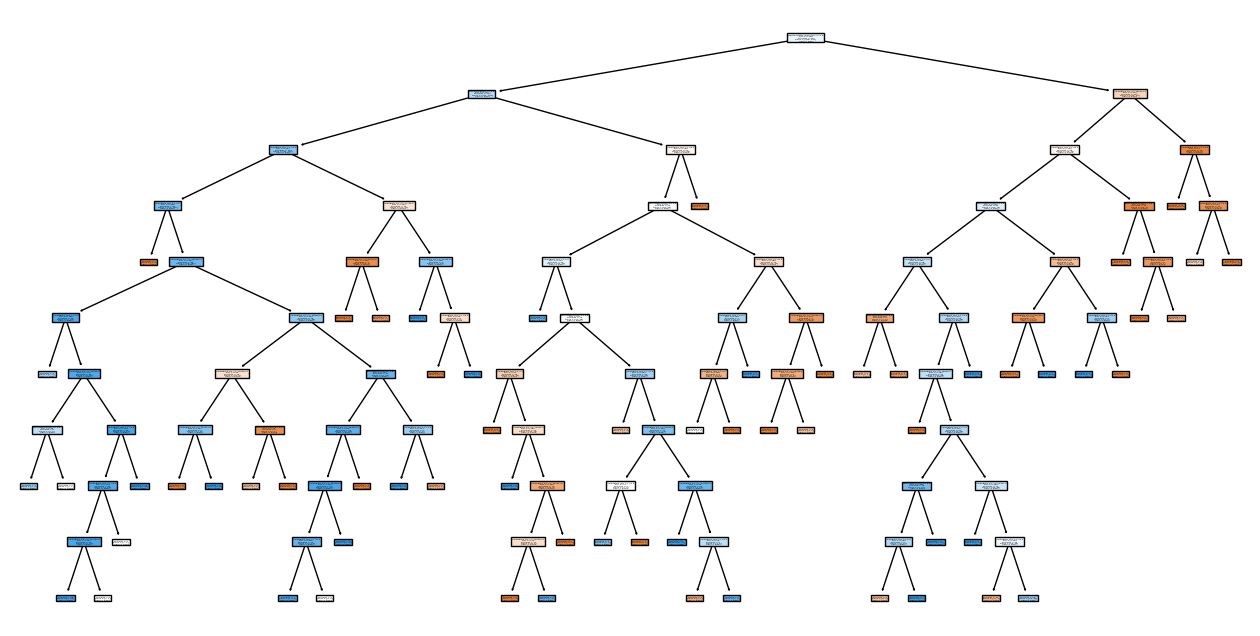

In [92]:
plt.figure(figsize=(16,8))
plot_tree(rf_best.estimators_[59], feature_names = fraud_check4.columns,class_names=fraud_check1['Taxable.Category'].unique(),filled=True)
plt.show()